In [1]:
import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\helper")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\mujoco_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\gpt_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\detection_module")

from mujoco_parser import *
from utility import *
from transformation import *

#sys.path.append('../package/helper/')
#sys.path.append('../package/mujoco_usage/')
#sys.path.append('../package/gpt_usage/')
#sys.path.append('../package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

c:\Users\ptfc0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready.


In [2]:
import mujoco as mj
from mujoco.glfw import glfw
import OpenGL.GL as gl
from PIL import Image
import numpy as np
import sim_utils
import Functions as F

class MujocoEnv:
    def __init__(self, xml_path, simend=300):
        self.xml_path = xml_path
        self.simend = simend

        # Load model & data
        self.model = mj.MjModel.from_xml_path(xml_path)
        self.data = mj.MjData(self.model)

        # Identify relevant sites and bodies
        self.ee_site_name = "grip_site"
        self.target_body_name = "obj_box_06"
        self.ee_site_id = self.model.site(self.ee_site_name).id
        self.target_body_id = self.model.body(self.target_body_name).id

        # Initialize GLFW
        if not glfw.init():
            raise Exception("Failed to initialize GLFW")

        self.window = glfw.create_window(1200, 900, "Mujoco Env", None, None)
        if not self.window:
            glfw.terminate()
            raise Exception("Failed to create GLFW window")

        glfw.make_context_current(self.window)
        glfw.swap_interval(1)

        # Set callbacks
        glfw.set_key_callback(self.window, sim_utils.keyboard(self.model, self.data))
        glfw.set_mouse_button_callback(self.window, sim_utils.mouse_button())
        glfw.set_cursor_pos_callback(self.window, sim_utils.mouse_move(self.model, None, None))  # scene and cam set later
        glfw.set_scroll_callback(self.window, sim_utils.scroll(self.model, None, None))          # scene and cam set later

        # Mujoco visualization objects
        self.cam = mj.MjvCamera()
        self.opt = mj.MjvOption()
        mj.mjv_defaultCamera(self.cam)
        mj.mjv_defaultOption(self.opt)
        self.scene = mj.MjvScene(self.model, maxgeom=10000)
        self.context = mj.MjrContext(self.model, mj.mjtFontScale.mjFONTSCALE_150.value)

        # Store scene and cam for mouse callback update
        glfw.set_cursor_pos_callback(self.window, sim_utils.mouse_move(self.model, self.scene, self.cam))
        glfw.set_scroll_callback(self.window, sim_utils.scroll(self.model, self.scene, self.cam))

        # Camera initial setup
        self.cam.azimuth = 89.608063
        self.cam.elevation = -1.588379
        self.cam.distance = 2.5
        self.cam.lookat = np.array([0.0, 0.0, 2.0])

        # Control callback setup
        mj.set_mjcb_control(None)

        self.captured = False
        self.rgb_img = None
        self.xyz_img_world = None
        self.saved_capture = False  # New flag to save only once

    def set_camera_to_named(self, cam_name):
        cam_id = self.model.camera(cam_name).id
        self.cam.type = mj.mjtCamera.mjCAMERA_FIXED
        self.cam.fixedcamid = cam_id
        print(f"Camera set to '{cam_name}' with id {cam_id}")

    def controller(self, model, data):
        # Your IK controller function here...
        nv = model.nv
        ee_pos = data.site_xpos[self.ee_site_id].copy()
        R_ee = data.site_xmat[self.ee_site_id].reshape(3, 3)

        box_pos = data.xpos[self.target_body_id].copy()
        target_pos = box_pos + np.array([0.0, 0.0, 0.10])  # 10 cm above box
        R_box = data.xmat[self.target_body_id].reshape(3, 3)

        R_box_rot = R_box @ F.RotX(np.pi / 2) @ F.RotY(-1 * np.pi / 2)

        pos_err = target_pos - ee_pos

        R_err = 0.5 * (np.cross(R_ee[:, 0], R_box_rot[:, 0]) +
                       np.cross(R_ee[:, 1], R_box_rot[:, 1]) +
                       np.cross(R_ee[:, 2], R_box_rot[:, 2]))

        error = np.hstack((pos_err, R_err))  # 6x1

        Jp = np.zeros((3, nv))
        Jr = np.zeros((3, nv))
        mj.mj_jacSite(model, data, Jp, Jr, self.ee_site_id)
        J_full = np.vstack((Jp, Jr))  # 6 x nv

        lam0 = 1e-3
        lam_scale = 1e-2
        lam = lam0 + lam_scale * np.linalg.norm(pos_err)
        A = J_full @ J_full.T + lam * np.eye(6)
        try:
            dq = J_full.T @ np.linalg.solve(A, error)
        except np.linalg.LinAlgError:
            dq = J_full.T @ np.linalg.pinv(A) @ error

        max_dq_norm = 0.2
        dq_norm = np.linalg.norm(dq)
        if dq_norm > max_dq_norm:
            dq *= max_dq_norm / dq_norm
        alpha = 0.25
        dq_step = alpha * dq

        q = data.qpos[:nv].copy()
        q_des = q + dq_step

        Kp = 200
        Kd = 10.0
        q_err = q_des - q
        qd = data.qvel[:nv].copy()
        f = data.qfrc_bias.copy()
        tau = (Kp * q_err) + (Kd * (-qd)) + f

        torque_limit = 200.0
        tau = np.clip(tau, -torque_limit, torque_limit)
        data.qfrc_applied[:] = tau
    
    def is_viewer_alive(self):
        return not glfw.window_should_close(self.window)

    def reset(self):
        mj.mj_resetData(self.model,self.data)
        self.data.time=0
        self.captured-False
        print("Environment Reset")

    def plot_text(self, p, label, size=10, rgba=(1,1,1,1)):
        marker = mj.MjvMarker()
        marker.type = mj.mjtGeom.mjGEOM_TEXT
        marker.pos = p
        marker.text = label.encode('utf-8')
        marker.size = size
        marker.rgba = rgba
    # Store the marker to be added each frame
        if not hasattr(self, '_text_markers'):
            self._text_markers = []
        self._text_markers.append(marker)

    def init_viewer(self,
                    transparent=False,
                    azimuth=89.608063,
                    distance=3,
                    elevation=-11.588379,
                    lookat=[0,0,2]):
        self.cam.azimuth=azimuth
        self.cam.elevation=elevation
        self.cam.distance=distance
        self.cam.lookat[:]=lookat

    def set_state(self,qpos=None,qvel=None):
        if qpos is not None:
            self.data.qpos[:len(qpos)]=qpos
        if qvel is not None:
            self.data.qvel[:len(qvel)]=qvel
            mj.mj_forward(self.model,self.data)

    def grab_mujoco_rgb_image(self, viewport_width, viewport_height):
        gl.glPixelStorei(gl.GL_PACK_ALIGNMENT, 1)
        pixels = gl.glReadPixels(0, 0, viewport_width, viewport_height, gl.GL_RGBA, gl.GL_UNSIGNED_BYTE)
        image = np.frombuffer(pixels, dtype=np.uint8).reshape(viewport_height, viewport_width, 4)
        image = np.flip(image, axis=0)  # Flip vertically
        return Image.fromarray(image)

    def depth_to_xyz(self, depth_img, cam, viewport_width, viewport_height):
        # Remove dividing by (2**24 - 1) because depth_img from OpenGL is already normalized [0,1]
        depth = depth_img.astype(np.float32)

        near = 0.01
        far = 1000.0
        # Convert depth buffer values to linear depth in meters
        z_linear = near * far / (far - (far - near) * depth)
        cam_id=self.model.camera("standing_cam2").id
        fovy_deg=self.model.cam_fovy[cam_id]
        # Camera intrinsics parameters (assumed pinhole camera model)
        fovy_rad = np.deg2rad(fovy_deg)  # Field of view in radians (adjust if needed)
        fy = viewport_height / (2 * np.tan(fovy_rad / 2))
        fx = fy
        cx = viewport_width / 2
        cy = viewport_height / 2

        x = np.arange(viewport_width)
        y = np.arange(viewport_height)
        xv, yv = np.meshgrid(x, y)

        X = (xv - cx) * z_linear / fx
        Y = (yv - cy) * z_linear / fy
        Z = z_linear

        xyz = np.stack([X, Y, Z], axis=-1)
        return xyz

    
    def cam_spherical_to_pose(self, cam_name):
        if cam_name == "standing_cam2":
            cam_pos = np.array([-2.55, 0.0, 2.25])  # From XML

            x_axis = np.array([0.0, -1.0, 0.0])
            y_axis = np.array([0.618, 0.0, 0.786])
            z_axis = np.cross(x_axis, y_axis)

            # Normalize just in case
            x_axis /= np.linalg.norm(x_axis)
            y_axis /= np.linalg.norm(y_axis)
            z_axis /= np.linalg.norm(z_axis)

            cam_rot = np.stack([x_axis, y_axis, z_axis], axis=1)
            return cam_pos, cam_rot

        else:
            raise ValueError(f"Camera {cam_name} not handled manually. Please add its pose here.")




    def run(self):
        while not glfw.window_should_close(self.window):
            simstart = self.data.time

            while (self.data.time - simstart < 1.0 / 60.0):
                mj.mj_step(self.model, self.data)

            if self.data.time >= self.simend:
                break

            viewport_width, viewport_height = glfw.get_framebuffer_size(self.window)
            viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

            mj.mjv_updateScene(self.model, self.data, self.opt, None, self.cam,
                            mj.mjtCatBit.mjCAT_ALL.value, self.scene)
            mj.mjr_render(viewport, self.scene, self.context)

            # ✅ Capture only once
            if not self.captured:
                # Grab RGB image
                img = self.grab_mujoco_rgb_image(viewport_width, viewport_height)
                img.save("camera_capture.png")
                print("Saved camera_capture.png")
                self.rgb_img = np.array(img)

                # Read depth buffer
                depth_buffer = gl.glReadPixels(0, 0, viewport_width, viewport_height,
                                            gl.GL_DEPTH_COMPONENT, gl.GL_FLOAT)
                depth_img = np.frombuffer(depth_buffer, dtype=np.float32).reshape(viewport_height, viewport_width)
                depth_img = np.flip(depth_img, axis=0)

                print(f"Depth min: {depth_img.min()}, max: {depth_img.max()}")

                # Convert depth to xyz in camera frame
                xyz_img = self.depth_to_xyz(depth_img, self.cam, viewport_width, viewport_height)
                print(f"Sample xyz points at center:\n{xyz_img[viewport_height//2-2:viewport_height//2+3, viewport_width//2-2:viewport_width//2+3, :]}")

                # Get camera pose
                cam_pos, cam_mat = self.cam_spherical_to_pose("standing_cam2")
                print(f"Camera position: {cam_pos}")
                print(f"Camera rotation matrix:\n{cam_mat}")

                # Transform points
                xyz_flat = xyz_img.reshape(-1, 3).T
                xyz_world_flat = cam_mat @ xyz_flat + cam_pos.reshape(3, 1)
                self.xyz_img_world = xyz_world_flat.T.reshape(viewport_height, viewport_width, 3)
                np.save("xyz_img_world.npy", self.xyz_img_world)


                print("Captured xyz point cloud in world coordinates.")
                self.captured = True

            glfw.swap_buffers(self.window)
            glfw.poll_events()

        glfw.terminate()


    def close(self):
        glfw.terminate()

if __name__ == "__main__":
    xml_path = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\franka_panda_w_objs.xml"
    env = MujocoEnv(xml_path)
    env.set_camera_to_named("standing_cam2")
    env.run()

    # Now you can load the saved data in another script as:
    #
    # import numpy as np
    # xyz_img_world = np.load("xyz_img_world.npy")
    # from PIL import Image
    # rgb_img = np.array(Image.open("camera_capture.png"))


Camera set to 'standing_cam2' with id 1
Saved camera_capture.png
Depth min: 9.530783427180722e-05, max: 0.04592633619904518
Sample xyz points at center:
[[[-0.   -0.    0.01]
  [-0.   -0.    0.01]
  [ 0.   -0.    0.01]
  [ 0.   -0.    0.01]
  [ 0.   -0.    0.01]]

 [[-0.   -0.    0.01]
  [-0.   -0.    0.01]
  [ 0.   -0.    0.01]
  [ 0.   -0.    0.01]
  [ 0.   -0.    0.01]]

 [[-0.    0.    0.01]
  [-0.    0.    0.01]
  [ 0.    0.    0.01]
  [ 0.    0.    0.01]
  [ 0.    0.    0.01]]

 [[-0.    0.    0.01]
  [-0.    0.    0.01]
  [ 0.    0.    0.01]
  [ 0.    0.    0.01]
  [ 0.    0.    0.01]]

 [[-0.    0.    0.01]
  [-0.    0.    0.01]
  [ 0.    0.    0.01]
  [ 0.    0.    0.01]
  [ 0.    0.    0.01]]]
Camera position: [-2.55  0.    2.25]
Camera rotation matrix:
[[ 0.    0.62 -0.79]
 [-1.    0.    0.  ]
 [ 0.    0.79  0.62]]
Captured xyz point cloud in world coordinates.


In [3]:
from PIL import Image
png_path = r'C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\camera_capture.png'
img = Image.open(png_path)   # PIL Image object
img.show()

In [4]:
# Instantiate GPT4V helper
GPT = GPT4VchatClass(
    gpt_model = "gpt-4o", #"gpt-4-vision-preview",
    role_msg  = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
    key_path  = r"C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt",
)
print ("Ready.")

key_path:[C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-anot
her-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

Ready.


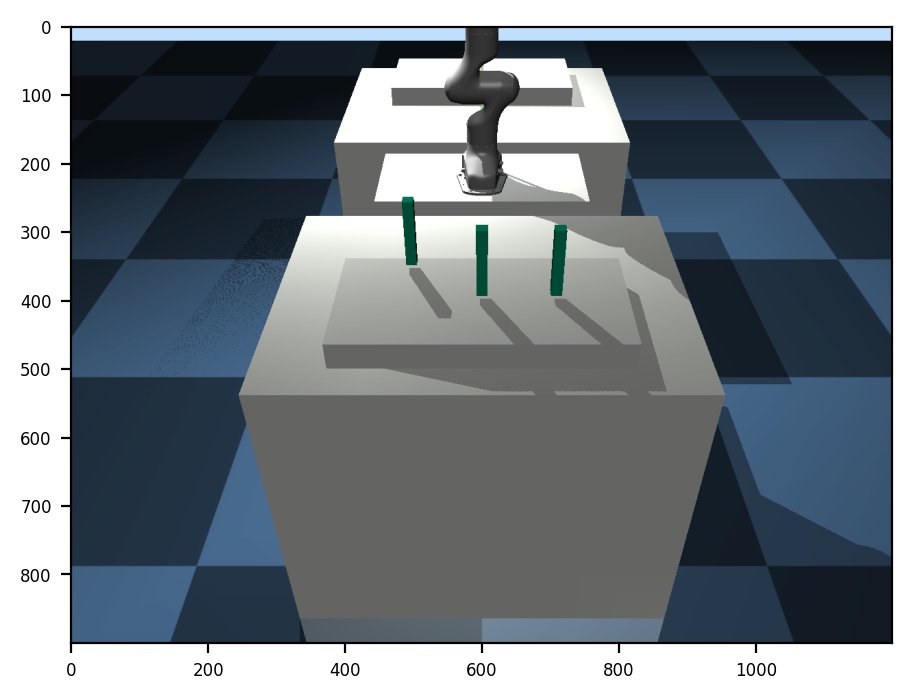

[USER_MSG]

<img1>Describe the image.

[GPT_OUTPUT]

The image shows a robotic arm above a platform with three upright green rods. The setup is on a checkered blue and black floor. The robotic arm is attached to a base on a raised platform behind the one with the rods. This appears to be a simulation or test setup for robotic manipulation.

[USER_MSG]


        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand. 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        

[GPT_OUTPUT]

Certainly! Based on the image, here's a JSON format listing the objects:

```json
{
  "objects": [
    "green rod 1",
    "green rod 2",
    "green rod 3"
  ]
}
```

These objects are suitable for detection and manipulation by the robotic arm, considering their size relative to the robotic hand.

Done.


In [7]:
# Plot
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.show()
# Describe the image
GPT.chat(
    user_msg = "<img1>Describe the image.",
    images   = [png_path],
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = False,
    MAX_TOKENS       = 512,
)
# List down the objects in the scene
ret = GPT.chat(
    user_msg = """
        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand. 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)
print ("Done.")

object_names:['green rod 1', 'green rod 2', 'green rod 3']


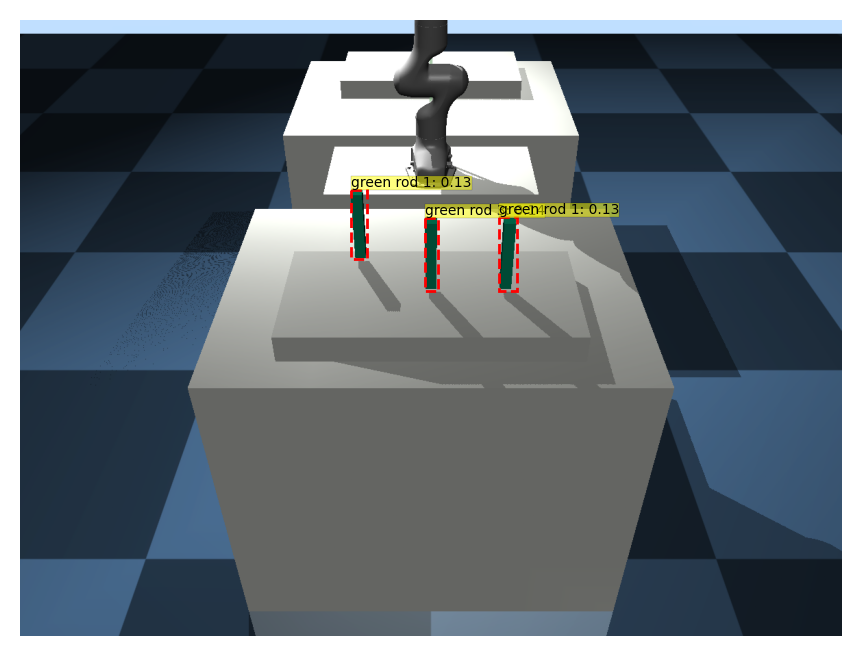

In [8]:
# Parse object names
json_string = ret[ret.find('{'):ret.rfind('}')+1]
data = json.loads(json_string)
object_names = data['objects']
print ("object_names:%s"%(object_names))

# Open-vocab detection
owlvit = Owlv2()
detection_result = owlvit.detect_objects(
    image_path    = png_path,
    object_names  = object_names,
    box_threshold = 0.1,
)

# Plot detection results
plot_detection_result(
    image_path       = png_path,
    detection_result = detection_result,
    figsize          = (6,4),
    fontsize         = 5,
)

In [9]:
import numpy as np
from PIL import Image
xyz_img_world = np.load("xyz_img_world.npy")
rgb_img = np.array(Image.open("camera_capture.png"))


In [10]:
# Get point cloud xyz for each detected bounding box
xyz_bboxes = []
for box in detection_result['boxes']:
    # Scale bounding box coordinates to match xyz_img_world resolution
    scale_factor = xyz_img_world.shape[0] / rgb_img.shape[0]
    x1, y1, x2, y2 = (box * scale_factor).int()

    # Extract the 3D points within the bounding box area from xyz_img_world
    xyz = xyz_img_world[y1:y2+1, x1:x2+1, :].reshape(-1, 3)  # [M x 3]
    xyz_bboxes.append(xyz)
    print(xyz_img_world)
    
# Exclude overlapping point clouds (assuming this function is implemented)
xyz_bboxes_unique = exclude_overlapping_pcd_within_list(xyz_bboxes)

# Get processed object point clouds and their centers
xyz_objects = []
xyz_centers = []
for xyz in xyz_bboxes_unique:
    # Discretize z values to detect floor height robustly
    z_discretized = np.round(xyz[:, 2] / 0.01) * 0.01
    unique, counts = np.unique(z_discretized, return_counts=True)
    k = int(len(unique) * 0.5)  # Use top 50% of height bins for floor detection
    top_k_indices = np.argsort(counts)[-k:]
    top_k_unique_values = unique[top_k_indices]

    # Estimate floor height and filter points above floor + offset
    z_floor = np.min(top_k_unique_values) + 0.005
    xyz_object = xyz[xyz[:, 2] >= z_floor]
    xyz_objects.append(xyz_object)

    # Fit a circle to the object's xy points to find center and radius
    xy_object = xyz_object[:, :2]
    xy_center, radius = fit_xy_circle(xy_object)
    xyz_centers.append(np.append(xy_center, z_floor))

print("Done.")

[[[-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  ...
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]]

 [[-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  ...
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]]

 [[-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  ...
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]]

 ...

 [[-2.56  0.01  2.26]
  [-2.56  0.01  2.26]
  [-2.56  0.01  2.26]
  ...
  [-2.56 -0.01  2.26]
  [-2.56 -0.01  2.26]
  [-2.56 -0.01  2.26]]

 [[-2.56  0.01  2.26]
  [-2.56  0.01  2.26]
  [-2.56  0.01  2.26]
  ...
  [-2.56 -0.01  2.26]
  [-2.56 -0.01  2.26]
  [-2.56 -0.01  2.26]]

 [[-2.56  0.01  2.26]
  [-2.56  0.01  2.26]
  [-2.56  0.01  2.26]
  ...
  [-2.56 -0.01  2.26]
  [-2.56 -0.01  2.26]
  [-2.56 -0.01  2.26]]]
[[[-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  [-2.56  0.01  2.25]
  ...
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]
  [-2.56 -0.01  2.25]]

 [[-2.56  0.01

In [11]:
# Get processed object point clouds and their centers
xyz_objects = []
xyz_centers = []
for i, xyz in enumerate(xyz_bboxes_unique):
    # Discretize z values to detect floor height robustly
    z_discretized = np.round(xyz[:, 2] / 0.01) * 0.01
    unique, counts = np.unique(z_discretized, return_counts=True)
    k = int(len(unique) * 0.5)  # Use top 50% of height bins for floor detection
    top_k_indices = np.argsort(counts)[-k:]
    top_k_unique_values = unique[top_k_indices]

    # Estimate floor height and filter points above floor + offset
    z_floor = np.min(top_k_unique_values) + 0.005
    xyz_object = xyz[xyz[:, 2] >= z_floor]
    xyz_objects.append(xyz_object)

    # Extract xy points and print debug info
    xy_object = xyz_object[:, :2]
    print(f"Object {i} - xy points shape: {xy_object.shape}")
    print(f"Object {i} - first few xy points:\n{xy_object[:5]}")

    # Fit a circle to the object's xy points to find center and radius
    xy_center, radius = fit_xy_circle(xy_object)
    xyz_centers.append(np.append(xy_center, z_floor))

print(f"Number of detected bounding boxes: {len(detection_result['boxes'])}")
print("Centers found:")
print(xyz_centers)
print("Done.")


Object 0 - xy points shape: (0, 2)
Object 0 - first few xy points:
[]
Object 1 - xy points shape: (0, 2)
Object 1 - first few xy points:
[]
Object 2 - xy points shape: (0, 2)
Object 2 - first few xy points:
[]
Number of detected bounding boxes: 3
Centers found:
[array([0.  , 0.  , 2.27]), array([0.  , 0.  , 2.27]), array([0.  , 0.  , 2.27])]
Done.


In [12]:
import numpy as np

# Assuming detection_result['boxes'], xyz_img_world, and rgb_img are loaded already

# Check shapes for reference
print(f"xyz_img_world shape: {xyz_img_world.shape} (should be [height, width, 3])")
print(f"rgb_img shape: {rgb_img.shape} (should be [height, width, channels])")

# Calculate scale factor carefully (height scaling)
scale_factor = xyz_img_world.shape[0] / rgb_img.shape[0]
print(f"Scale factor: {scale_factor}")

for i, box in enumerate(detection_result['boxes']):
    # Scale bounding box coordinates to xyz_img_world resolution
    scaled_box = (box * scale_factor).int()
    x1, y1, x2, y2 = scaled_box
    
    print(f"\nBox {i} scaled coordinates (x1, y1, x2, y2): ({x1.item()}, {y1.item()}, {x2.item()}, {y2.item()})")
    
    # Extract the xyz patch from xyz_img_world
    xyz_patch = xyz_img_world[y1:y2+1, x1:x2+1, :]
    
    # Basic stats
    min_coords = xyz_patch.min(axis=(0,1))
    max_coords = xyz_patch.max(axis=(0,1))
    mean_coords = xyz_patch.mean(axis=(0,1))
    unique_points = np.unique(xyz_patch.reshape(-1, 3), axis=0)
    
    print(f"Box {i} xyz_patch shape: {xyz_patch.shape}")
    print(f"Box {i} min xyz: {min_coords}")
    print(f"Box {i} max xyz: {max_coords}")
    print(f"Box {i} mean xyz: {mean_coords}")
    print(f"Box {i} unique xyz points count: {unique_points.shape[0]}")
    
    # Show first few unique points if they exist
    if unique_points.shape[0] > 0:
        print(f"Box {i} first 5 unique xyz points:\n{unique_points[:5]}")
    else:
        print(f"Box {i} has no unique points!")

    # Optional: check for any NaNs or invalid data inside patch
    nan_count = np.isnan(xyz_patch).sum()
    print(f"Box {i} contains {nan_count} NaN values in xyz_patch")









xyz_img_world shape: (900, 1200, 3) (should be [height, width, 3])
rgb_img shape: (900, 1200, 4) (should be [height, width, channels])
Scale factor: 1.0

Box 0 scaled coordinates (x1, y1, x2, y2): (483, 247, 506, 348)
Box 0 xyz_patch shape: (102, 24, 3)
Box 0 min xyz: [-2.56  0.    2.25]
Box 0 max xyz: [-2.56  0.    2.26]
Box 0 mean xyz: [-2.56  0.    2.26]
Box 0 unique xyz points count: 2448
Box 0 first 5 unique xyz points:
[[-2.56  0.    2.25]
 [-2.56  0.    2.25]
 [-2.56  0.    2.25]
 [-2.56  0.    2.25]
 [-2.56  0.    2.25]]
Box 0 contains 0 NaN values in xyz_patch

Box 1 scaled coordinates (x1, y1, x2, y2): (591, 288, 609, 395)
Box 1 xyz_patch shape: (108, 19, 3)
Box 1 min xyz: [-2.56 -0.    2.26]
Box 1 max xyz: [-2.56  0.    2.26]
Box 1 mean xyz: [-2.56  0.    2.26]
Box 1 unique xyz points count: 2052
Box 1 first 5 unique xyz points:
[[-2.56 -0.    2.26]
 [-2.56 -0.    2.26]
 [-2.56 -0.    2.26]
 [-2.56 -0.    2.26]
 [-2.56 -0.    2.26]]
Box 1 contains 0 NaN values in xyz_patch



3D centers of detection boxes:
Box 0: X=-2.559, Y=0.001, Z=2.255
Box 1: X=-2.559, Y=0.000, Z=2.256
Box 2: X=-2.559, Y=-0.001, Z=2.256


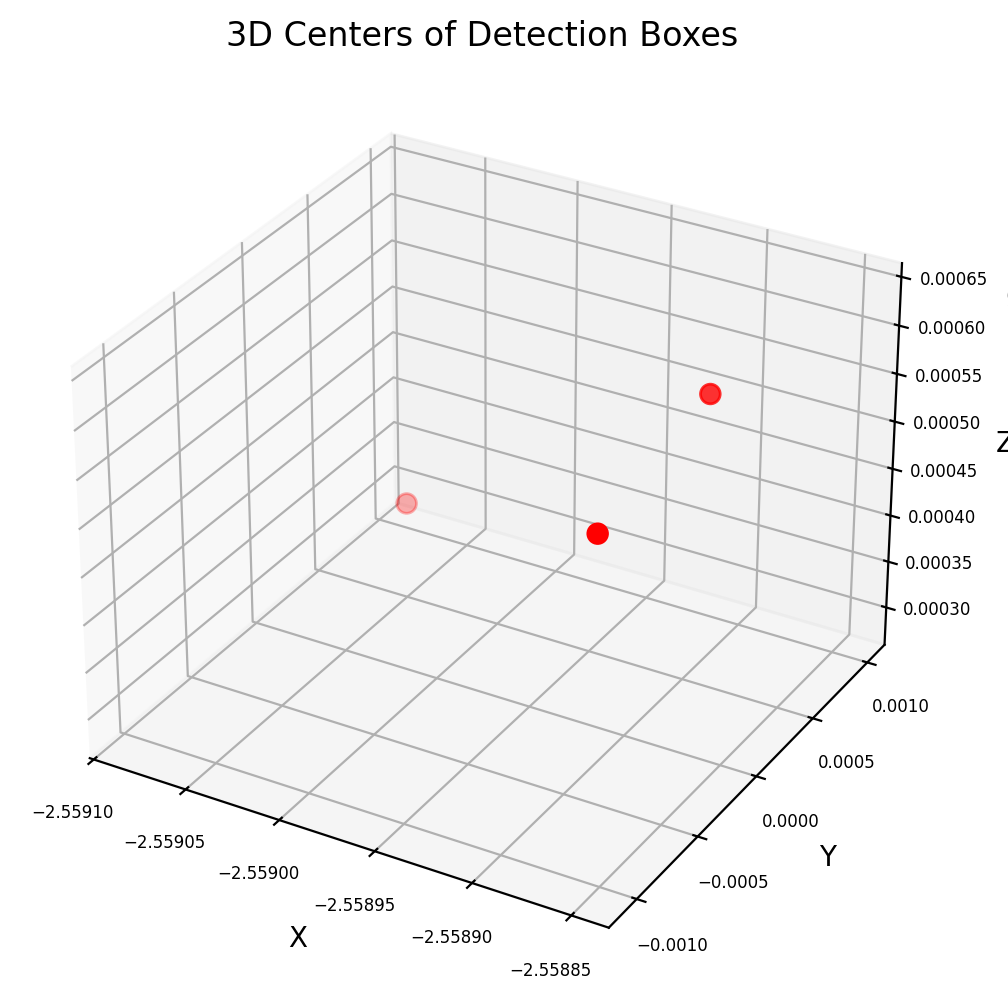

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

box_centers = []
scale_factor = xyz_img_world.shape[0] / rgb_img.shape[0]

print("3D centers of detection boxes:")

for i, box in enumerate(detection_result['boxes']):
    scaled_box = (box * scale_factor).int()
    x1, y1, x2, y2 = scaled_box
    
    xyz_patch = xyz_img_world[y1:y2+1, x1:x2+1, :]
    mean_coords = xyz_patch.mean(axis=(0,1))
    box_centers.append(mean_coords)
    
    print(f"Box {i}: X={mean_coords[0]:.3f}, Y={mean_coords[1]:.3f}, Z={mean_coords[2]:.3f}")

box_centers = np.array(box_centers)

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(box_centers[:, 0], box_centers[:, 1], box_centers[:, 2], c='r', marker='o', s=50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Centers of Detection Boxes')

plt.show()



In [15]:
for i, center in enumerate(xyz_centers):
    print(f"Box {i} refined center 3D coordinate: {center}")


Box 0 refined center 3D coordinate: [0.   0.   2.27]
Box 1 refined center 3D coordinate: [0.   0.   2.27]
Box 2 refined center 3D coordinate: [0.   0.   2.27]


In [ ]:
env.reset()
env.init_viewer(azimuth=170, distance=2.3, elevation=-35, lookat=[0.01, 0.1, -0.25], transparent=True)

# Render a single frame to update visuals
env.render()

# Now grab the current RGB image
render_img = env.grab_image(rsz_rate=1)  # assuming this grabs pixels from the viewer

# If you want to grab the center point cloud (e.g. from depth buffer)
# You’ll need to access depth data here, or if your env supports it:
xyz_centers = env.get_point_cloud_center()  # hypothetical method, replace with your actual

# Show the image immediately
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.imshow(render_img)
plt.title(f"Initial View")
plt.axis('off')
plt.show()

# Close viewer since we're done
env.close_viewer()

print ("Done.")

Environment Reset


AttributeError: 'MujocoEnv' object has no attribute 'render'

In [ ]:
# Store current GPT message
gpt_state = GPT.get_state()
print ("GPT state ready.")

GPT state ready.


In [ ]:
# Set GPT state
GPT.set_state(state=gpt_state)
ret = GPT.chat(
    user_msg = """
        xyz_centers in the code holds the point centers for each detected object can u tell me what those are?
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)

[USER_MSG]


        xyz_centers in the code holds the point centers for each detected object can u tell me what those are?
        

[GPT_OUTPUT]

In the context of object detection in 3D environments, `xyz_centers` typically represents the central coordinates of detected objects in a 3D space. Each entry would be a tuple or list containing the X, Y, and Z coordinates.

The coordinates provide the position of the center of each object, helping to locate them relative to the robot. This information is crucial for tasks like picking and placing objects.

Without specific values, a general example of `xyz_centers` might look like this:

```json
{
  "xyz_centers": [
    [1.0, 2.0, 0.5],  // Center for object 1
    [3.5, 1.5, 0.2],  // Center for object 2
    [2.2, 0.8, 0.7]   // Center for object 3
  ]
}
```

Each sub-list or tuple represents the X, Y, and Z coordinates for the center of an object.